In [6]:

%pip install openreview-py -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/4c/20/93f7977bf8a43e7fd63e81e409ed5a4817d3e787ab5702c5f26960eba1b2/openreview_py-1.39.3-py2.py3-none-any.whl (627 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip show openreview

Note: you may need to restart the kernel to use updated packages.


In [46]:

import openreview
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from scipy.stats import norm
from collections import Counter
import collections
import itertools
from math import comb
import json
from datetime import datetime
import math

In [14]:
print(dir(openreview))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'const', 'extract_forum', 'extract_note', 'main']
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(1, 1, 6)
(1, 1, 7)
(1, 1, 8)
(1, 1, 9)
(1, 1, 10)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 2, 10)
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 4, 1)
(1, 4, 2)
(1, 4, 3)
(1, 4, 4)
(1, 4, 5)
(1, 4, 6)
(1, 4, 7)
(1, 4, 8)
(1, 4, 9)
(1, 4, 10)
(1, 5, 1)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 5)
(1, 5, 6)
(1, 5, 7)
(1, 5, 8)
(1, 5, 9)
(1, 5, 10)
(1, 6, 1)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(1, 6, 6)
(1, 6, 7)
(1, 6, 8)
(1, 6, 9)
(1, 6, 10)
(1, 7, 1)
(1, 7, 2)
(1, 7, 3)
(1, 7, 4)
(1, 7, 5)
(1, 7, 6)
(1, 7, 7)
(1, 7, 8)
(1, 7, 9)
(1, 7, 10)
(1, 8, 1)
(1, 8, 2)
(1, 8, 3)
(1, 8, 4)
(1, 8, 5)
(1, 8, 6)
(1, 8, 7)
(1, 8, 8)
(1, 8, 9)
(1, 8, 10)
(1, 9, 1)
(1, 9, 2)
(1,

In [13]:
"""
Load the data
"""
def extract_number(string):
    colon_index = string.find(":")
    if colon_index != -1:
        number_str = string[:colon_index].strip()
        if number_str.isdigit():
            return int(number_str)

client = openreview.Client(baseurl='https://api.openreview.net')

    
submissions = client.get_all_notes(
    invitation="ICLR.cc/2023/Conference/-/Blind_Submission",
    details='directReplies'
)

papers = [] 
# for submission in submissions:
#     authorids = submission.content['authorids']
#     scores = []
#     for reply in submission.details["directReplies"]:
#         print(reply)
#         if reply["invitation"].endswith("Decision"):
#             forum = reply['forum']
#             decision = reply['content']['decision']
#         if reply["invitation"].endswith("Official_Review"):
#             score = extract_number(reply['content']['rating'])
#             scores += [score]
#         if reply['id'] == 'MXV1TACjo_':
#             print()
#     review = {'forum': forum, 'authorids': authorids, 'decision': decision, 'scores': scores}
#     papers.append(review)
    
    
    
with open('papers_2021.json', 'r') as file:
    papers = json.load(file)
papers[0]

Getting V1 Notes: 100%|█████████▉| 3794/3798 [00:10<00:00, 361.24it/s]


{'forum': 'trPMYEn1FCX',
 'authorids': ['ucabab6@ucl.ac.uk',
  'rrg27@cam.ac.uk',
  'r.gray@ucl.ac.uk',
  'ashwani.jha@ucl.ac.uk',
  'p.nachev@ucl.ac.uk'],
 'decision': 'Reject',
 'scores': [3, 4, 5, 5]}

In [14]:
"""
Some tool functions
"""

def count_scores_by_length(lst, k):
    counts = {}
    for item in lst:
        scores = item.get('scores', [])
        if len(scores) == k:
            counts[k] = counts.get(k, 0) + 1
    return counts

def count_keys_with_value(dictionary, v):
    count = 0
    for value in dictionary.values():
        if value == v:
            count += 1
    return count

def get_keys_with_value(dictionary, v):
    keys_with_value = []
    for key, value in dictionary.items():
        if value == v:
            keys_with_value.append(key)
    return keys_with_value

count_scores_by_length(papers, 3)

{3: 520}

mean score = 5.51073217726397 
std of score = 1.0093838772209565


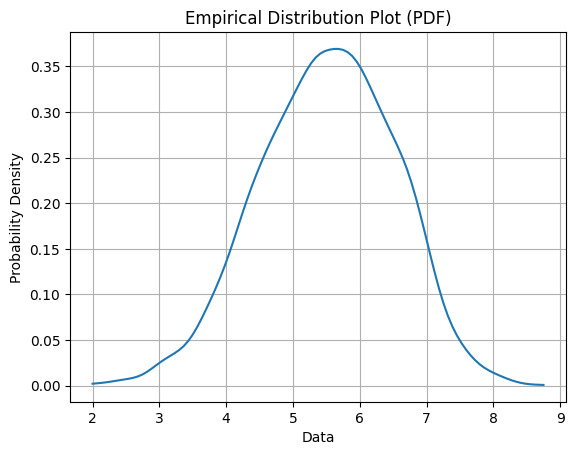

In [15]:
# learn the prior of paper quality. See Appendix C for the detials of the model

n = len(papers)
score_list_avg = np.zeros(n)
for i in range(n):
    score_list_avg[i] = np.average(papers[i]['scores'])
    
mu_q = np.average(score_list_avg)
sig_q = np.std(score_list_avg)
print('mean score =', mu_q, '\nstd of score =', sig_q)

def plot_empirical_distribution(data):
    # Estimate the probability density function (PDF)
    kde = gaussian_kde(data)

    # Generate a range of values for x-axis
    x = np.linspace(min(data), max(data), 100)

    # Evaluate the PDF at the given x values
    pdf = kde.evaluate(x)

    # Plot the empirical distribution
    plt.plot(x, pdf)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.title('Empirical Distribution Plot (PDF)')
    plt.grid(True)
    plt.show()
    
plot_empirical_distribution(score_list_avg)

Fitted t: -0.513295875088361


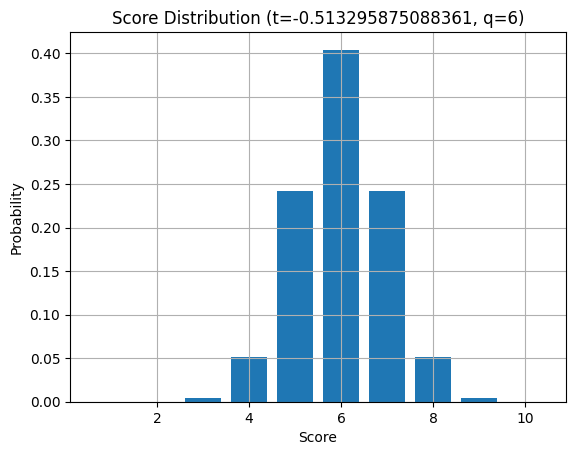

In [16]:
# learn the review noise

def fit_parameter_t(data):
    # Define the log-likelihood function
    def log_likelihood(t):
        log_likelihood_val = 0

        for entry in data:
            scores = np.array(entry)
            q = np.mean(scores)
            log_denominator = np.log(np.sum(np.exp(t * (np.arange(1, 11) - q)**2)))
            log_likelihood_val += np.sum(t * (scores - q)**2 - log_denominator)

        return -log_likelihood_val

    # Initial guess for parameter t
    initial_t = 1.0

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_likelihood, initial_t, method='BFGS')

    fitted_t = result.x[0]
    return fitted_t

n = len(papers)
score_list = []
for i in range(n):
    score_list.append(papers[i]['scores'])

t = fit_parameter_t(score_list)
print("Fitted t:", t)

def plot_score_distribution(t, q):
    scores = np.arange(1, 11)
    probabilities = np.exp(t * (scores - q)**2) / np.sum(np.exp(t * (scores - q)**2))

    plt.bar(scores, probabilities)
    plt.xlabel('Score')
    plt.ylabel('Probability')
    plt.title('Score Distribution (t={}, q={})'.format(t, q))
    plt.grid(True)
    plt.show()
    
plot_score_distribution(t, 6)

In [17]:
# learn the prior of number of papers each author has
# Assign papers to the author with the most papers

def find_most_common_string(dictionary):
    string_counts = {}

    for values in dictionary.values():
        for string in values:
            string_counts[string] = string_counts.get(string, 0) + 1

    most_common_string = max(string_counts, key=string_counts.get)
    return most_common_string, string_counts[most_common_string]


def assign_authors_to_papers(paper_dict):
    assigned_papers = {}
    
    while paper_dict:
        author_max, count = find_most_common_string(paper_dict)
        if count == 1:
            for key, values in paper_dict.items():
                assigned_papers[key] = values[0]
            return assigned_papers

        papers_to_remove = []
        for key, values in paper_dict.items():
            if any(author_max in value for value in values):
                papers_to_remove.append(key)
                assigned_papers[key] = author_max

        for paper in papers_to_remove:
            del paper_dict[paper]


paper_author_map = {}
n = len(papers)
score_list = []
for i in range(n):
    paper_author_map[papers[i]['forum']] = papers[i]['authorids']

assigned_papers = assign_authors_to_papers(paper_author_map)

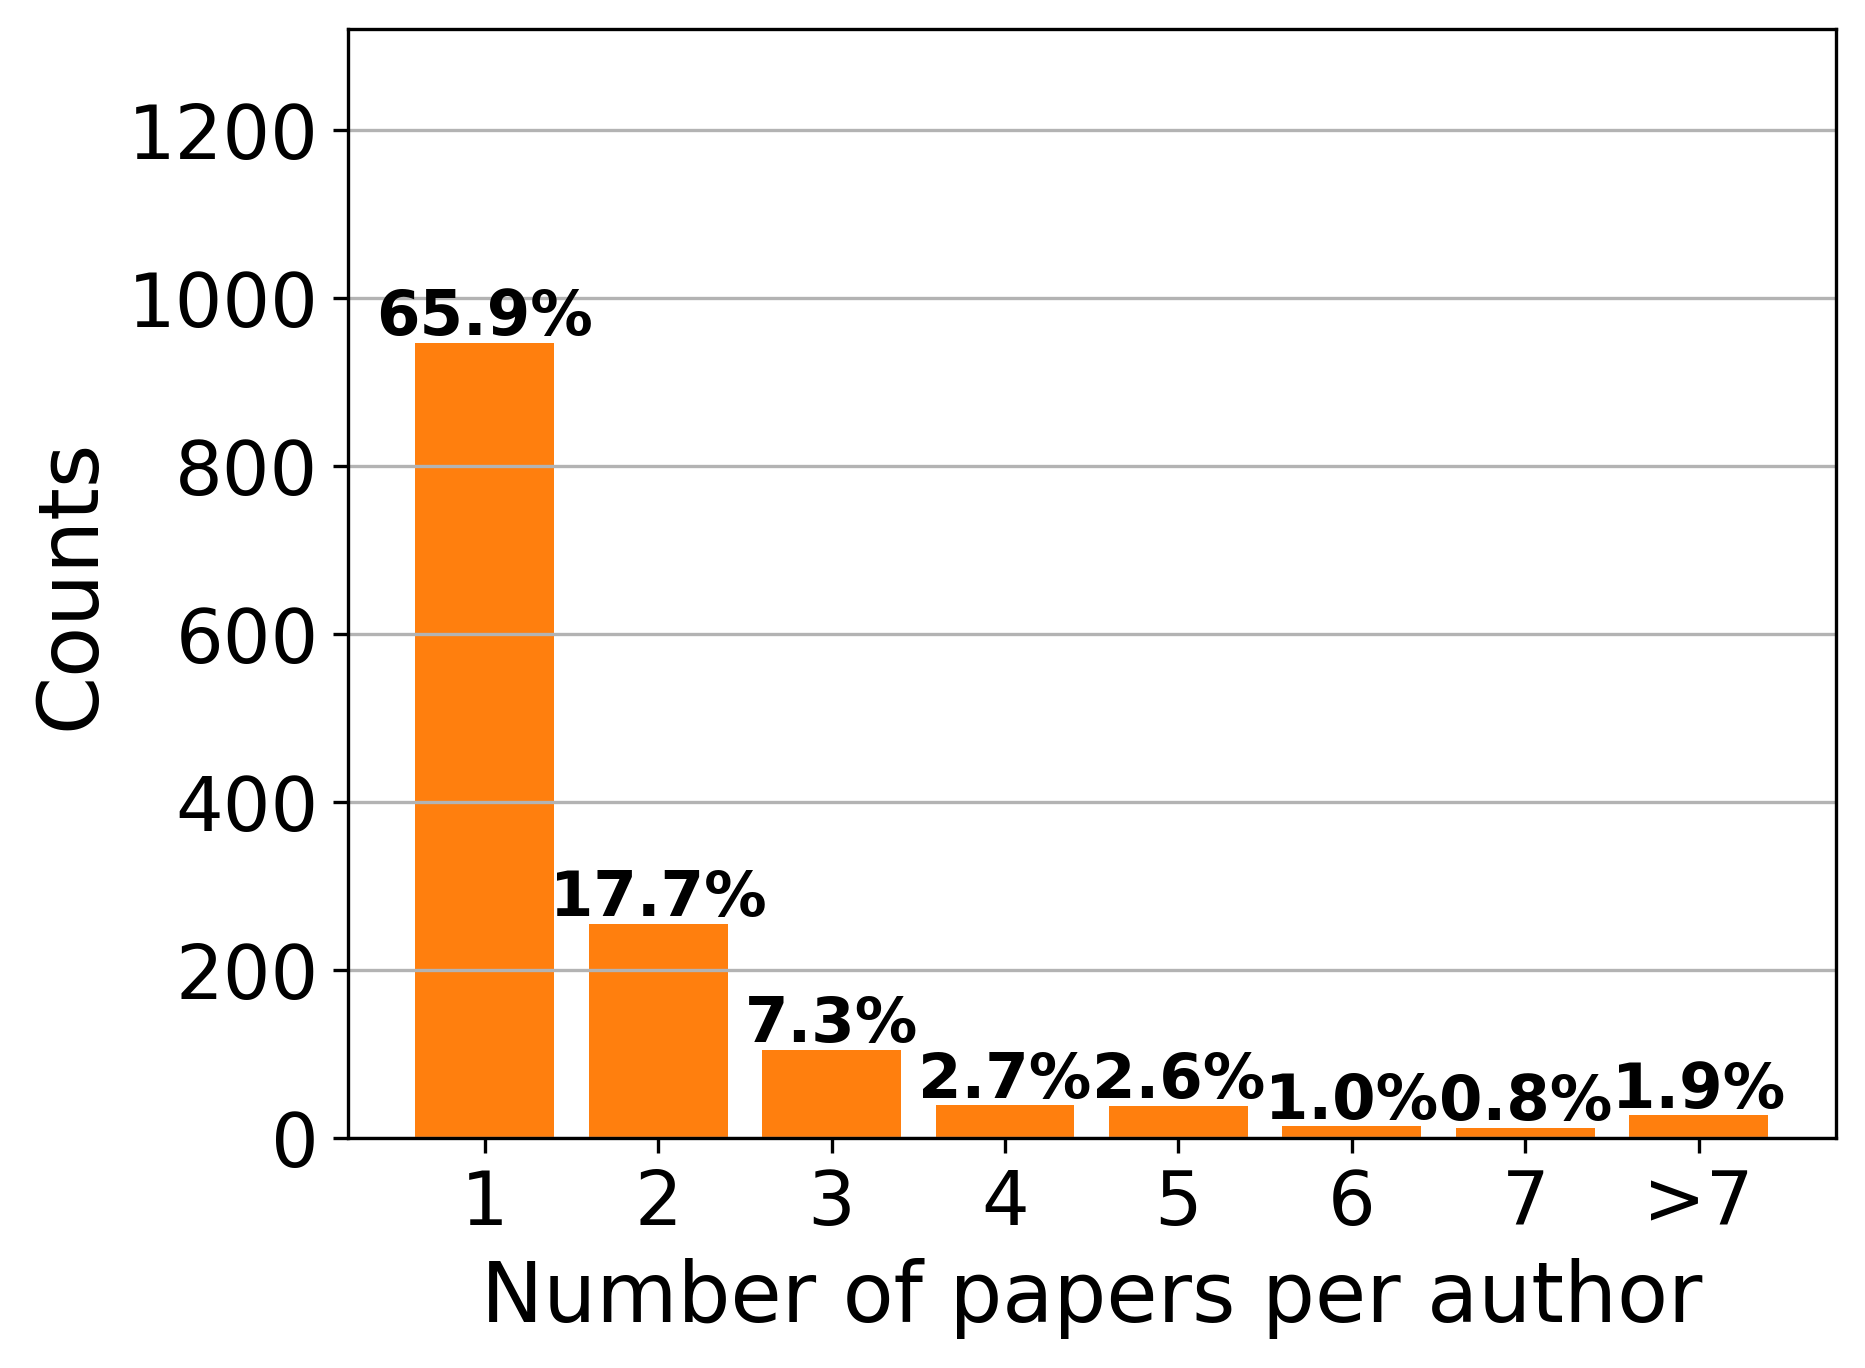

In [18]:
"Visualize the distirbution of the number of papers each author has"

def plot_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        if count <= 7:
            paper_counts[str(count)] = paper_counts.get(str(count), 0) + 1
        else:
            paper_counts['>7'] = paper_counts.get('>7', 0) + 1

    # Create the plot
    x = list(paper_counts.keys())[::-1]
    y = list(paper_counts.values())[::-1]

    fig, ax = plt.subplots(dpi = 300)
    plt.rcParams['figure.figsize'] = (8, 5)
    
    bars = ax.bar(
    x=x,
    height = y
    )
    
    plt.bar(x, y)
    plt.xlabel("Number of papers per author", fontsize = '20')
    plt.ylabel("Counts", fontsize = '20')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.yaxis.grid(True, color='#B3B3B3')
    ax.xaxis.grid(False)
    plt.ylim(0,1320)
    
    for i,bar in enumerate(bars):
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 10,
          str(np.round(y[i]/sum(y)*100, 1))+'%',
            fontsize = 15,
          horizontalalignment='center',
          color='black',
          weight='bold'
          )
    
def calculate_author_paper_distribution(paper_dict):
    author_paper_counts = {}

    # Count the number of papers for each author
    for author in paper_dict.values():
        author_paper_counts[author] = author_paper_counts.get(author, 0) + 1

    # Count the number of authors for each number of papers
    paper_counts = {}
    for count in author_paper_counts.values():
        paper_counts[count] = paper_counts.get(count, 0) + 1

    tmp = np.array(sorted(paper_counts.items()))
    N = np.sum(tmp[:, 1])
    frequency = tmp[:, 1] / N
    output = np.column_stack((tmp, frequency))
    output[:,:2] = output[:,:2].astype(int)
    return output

number_of_paper_frequency = calculate_author_paper_distribution(assigned_papers)
plot_author_paper_distribution(assigned_papers)
# print(number_of_paper_frequency, np.sum(number_of_paper_frequency[:,0]*number_of_paper_frequency[:,2]))

## The Softmax Review Model and the Mechanisms

In [215]:
"""
Define the model
"""

class RealConfParams:
    def __init__(self, n, k, mu_q, sig_q, t):
        self.n = n            # number of papers
        self.k = k            # number of reviews
        self.mu_q = mu_q      # mean of quality prior
        self.sig_q = sig_q    # std of quality prior
        self.t = t            # temperature of review noise
        
        
# draw samples from quality distribution
def sample_q(para, nmc):
    samples = np.random.normal(loc=para.mu_q, scale=para.sig_q, size=(nmc,para.n))
    return np.sort(samples, axis = 1, kind='quicksort')[:,::-1]

n = 20
k = 3

para = RealConfParams(
        n = n,
        k = k,
        mu_q = mu_q,
        sig_q = sig_q,
        t = t
        )

q_samples = sample_q(para, 1000)

In [216]:
"""
Compute possible thresholds
"""

def MAP_estimator_q(para, signals):
    t = para.t
    mu_q = para.mu_q
    sig_q = para.sig_q
    
    def log_MAP(q):
        log_prior = np.log(norm.pdf(q,mu_q, sig_q))
        sigs = np.array(signals)
        log_MAP_val = np.sum(t * (sigs - q)**2)+ log_prior

        return -log_MAP_val
    
    initial_q = 5

    # Minimize the negative log-likelihood to estimate t
    result = minimize(log_MAP, initial_q, method='BFGS')
    fitted_q = result.x[0]
    return fitted_q

global possible_thresholds
possible_thresholds = {}
for combination in itertools.combinations_with_replacement(range(1, 11), k):
    sorted_combination = tuple(sorted(combination))
    possible_thresholds[sorted_combination] = MAP_estimator_q(para, combination)
possible_thresholds = dict(sorted(possible_thresholds.items(), key = lambda item: item[1]))
print(possible_thresholds)

{(1, 1, 1): 1.5675017335683097, (1, 1, 2): 1.8587979014521387, (1, 2, 2): 2.150093850650375, (1, 1, 3): 2.150093973890292, (1, 2, 3): 2.441389962111501, (2, 2, 2): 2.4413900049564745, (1, 1, 4): 2.441390065839933, (2, 2, 3): 2.7326862069854165, (1, 3, 3): 2.7326862069854183, (1, 2, 4): 2.732686211126789, (1, 1, 5): 2.732686253235255, (1, 2, 5): 3.023982408277859, (1, 3, 4): 3.023982408277859, (2, 2, 4): 3.023982408277859, (2, 3, 3): 3.023982409014362, (1, 1, 6): 3.0239824406305775, (1, 2, 6): 3.315278571603202, (1, 4, 4): 3.315278599814551, (3, 3, 3): 3.315278599814551, (1, 3, 5): 3.315278605428929, (2, 2, 5): 3.315278605428929, (2, 3, 4): 3.315278605428929, (1, 1, 7): 3.3152786844485926, (1, 2, 7): 3.606574743071821, (1, 1, 8): 3.6065747687542724, (1, 3, 6): 3.6065747687542724, (2, 4, 4): 3.6065747792465226, (1, 4, 5): 3.6065747920877476, (2, 2, 6): 3.6065747920877476, (3, 3, 4): 3.606574792087748, (2, 3, 5): 3.606574802579999, (2, 2, 7): 3.897870962819866, (3, 3, 5): 3.89787096590534

In [220]:
def acceptance_probability(para, q, t_acc):
    t = para.t
    k = para.k
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)
    for combination in itertools.product(range(1, 11), repeat=k):
        sorted_combination = tuple(sorted(combination))
        estimated_q = possible_thresholds[sorted_combination]
        if estimated_q >= t_acc:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)
            # print(acc_probability.shape)
            
    return acc_probability

def parallel_quality_discrete(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    t = para.t
    
    q_acc = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*(q[:,i] - 5.5)
    return (np.average(q_acc), np.var(q_acc))

parallel_quality_discrete(para, q_samples, 5.6)

(11.258157810838842, 15.693830032228812)

In [222]:
def sequential_quality_discrete(para, q, t_acc, t_rev):
    t = para.t
    k = para.k
    n = para.n
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)

    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    p_rev = np.ones(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = acceptance_probability(para, q[:,i], t_acc)
        q_acc += p_acc*p_rev*(q[:,i] - 5.5)
        q_rev += p_rev*q[:,i]
        n_rev += p_rev
        p_rev *= acceptance_probability(para, q[:,i], t_rev)
     

    
    return (np.average(q_acc), np.average(n_rev))

sequential_quality_discrete(para, q_samples, 5.3, 5.3)

(11.593771417138658, 10.755384080753318)

In [ ]:
"""
This part is used to compute the optimal conference quality and reiview burden under different accetpance threshold.
Based on our observation that the optimal t_rev is usually equal to t_acc, we simply set t_rev = t_acc to save time in this experiment.
This takes hours to run, can skip.
"""

utility_parallel = []
utility_sequential = []
n_review_parallel = []
n_review_sequential = []

for i,t_acc in enumerate(possible_thresholds.values()):
    print(i+1, "of 120,", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    u_p = 0
    u_s = 0
    n_p = 0
    n_s = 0
    for item in number_of_paper_frequency:
        n = int(item[0])
        n_paper = int(item[1])
        freq = item[2]
        para = RealConfParams(
                n = n,
                k = k,
                mu_q = mu_q,
                sig_q = sig_q,
                t = t
                )
        q_samples = sample_q(para, 10000)
        u_p += parallel_quality_discrete(para, q_samples, t_acc)[0]*freq
        output_s = sequential_quality_discrete(para, q_samples, t_acc, t_acc)
        u_s += output_s[0]*freq
        n_p += n*n_paper
        n_s += output_s[1]*n_paper
    utility_parallel.append(u_p)
    utility_sequential.append(u_s)
    n_review_parallel.append(n_p)
    n_review_sequential.append(n_s)
    
# np.save('Numerical_results/Real_data/utility_parallel_2020.npy', utility_parallel)
# np.save('Numerical_results/Real_data/utility_sequential_2020.npy', utility_sequential)
# np.save('Numerical_results/Real_data/n_review_parallel_2020.npy', n_review_parallel)
# np.save('Numerical_results/Real_data/n_review_sequential_2020.npy', n_review_sequential)

[0.8056655345421495]
[0.8056655345421495, 0.8068192976306209]
[0.8056655345421495, 0.8068192976306209, 0.7724694995075947]


(0.6, 1.0)

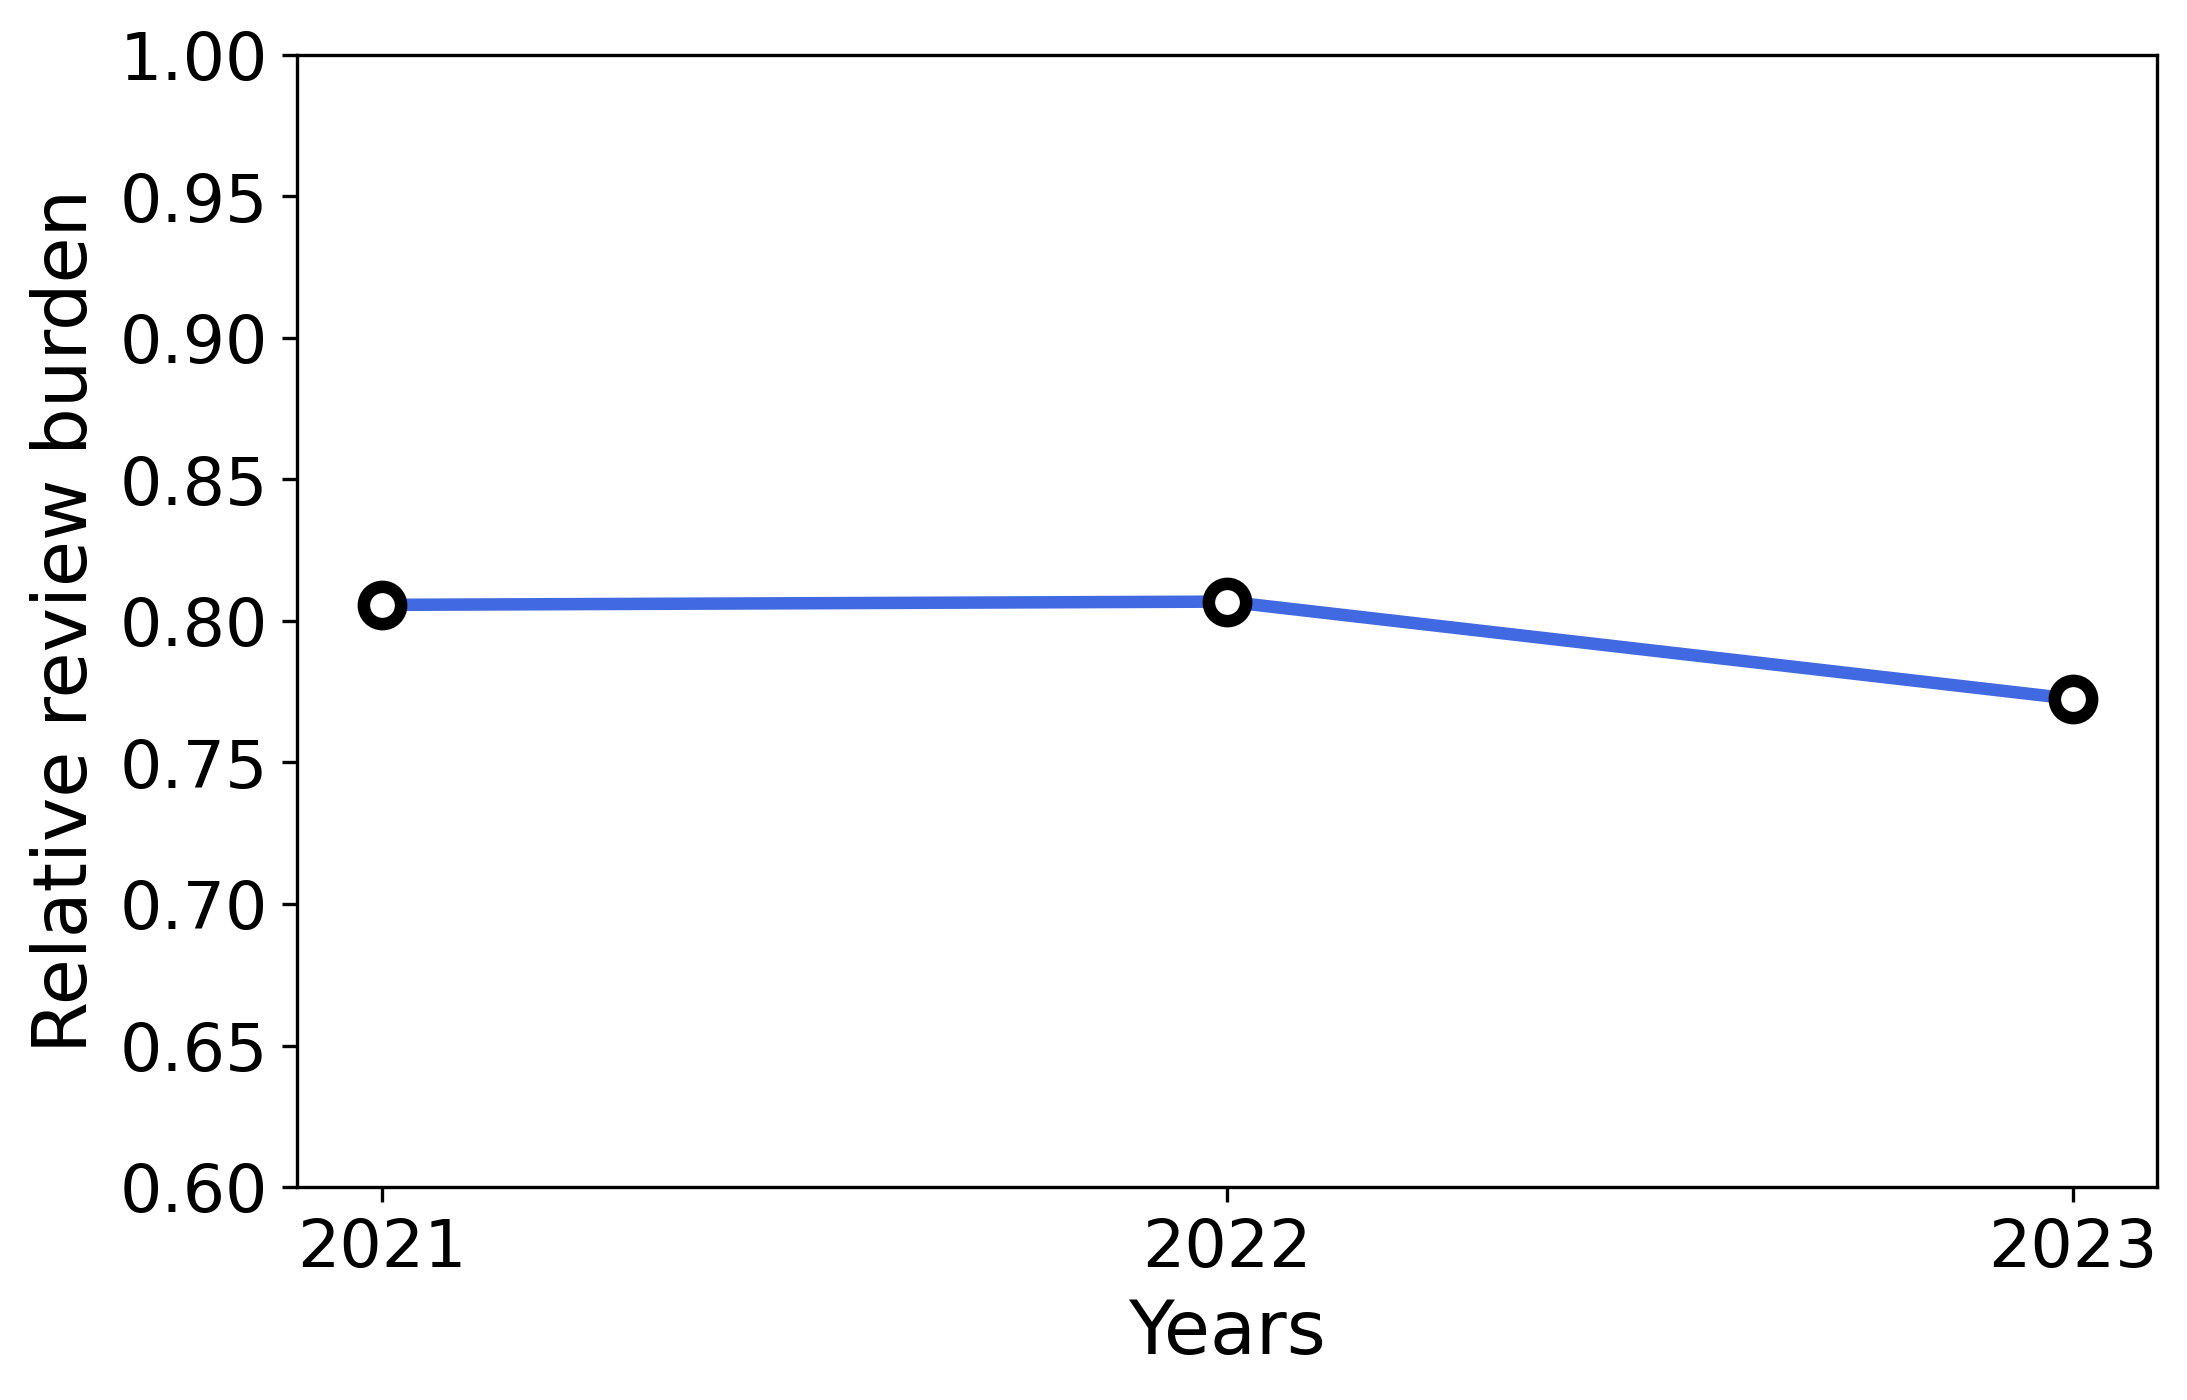

In [532]:
"""
Visualizing the relative review burden on real-data simulated model. See section 5.3.
"""

u_gain = []
r_reduce = []
for year in ['2021', '2022', '2023']:
    utility_parallel = np.load('Numerical_results/Real_data/utility_parallel_'+year+'.npy')
    utility_sequential = np.load('Numerical_results/Real_data/utility_sequential_'+year+'.npy')
    n_review_parallel = np.load('Numerical_results/Real_data/n_review_parallel_'+year+'.npy')
    n_review_sequential = np.load('Numerical_results/Real_data/n_review_sequential_'+year+'.npy')

    index = np.where(np.array(utility_sequential) >= np.max(utility_parallel))
    u_gain.append((np.max(utility_sequential) - np.max(utility_parallel))/np.max(utility_parallel))
    r_reduce.append(np.min(np.array(n_review_sequential)[index])/np.max(n_review_parallel))
    print(r_reduce)

fig, ax = plt.subplots(dpi = 300)
plt.rcParams['figure.figsize'] = (8, 5)
plt.scatter(['2021', '2022', '2023'], r_reduce, s = 80, edgecolor='black', linewidths=3, color = 'white')
plt.plot(['2021', '2022', '2023'], r_reduce, linewidth = 3, color = 'royalblue', zorder = 0)
plt.xlabel("Years", fontsize = '18')
plt.ylabel("Relative review burden", fontsize = '18')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.yaxis.grid(True, color='#B3B3B3')
# ax.xaxis.grid(False)
plt.ylim(0.6,1)

## Two phase

In [213]:
t1 = 6.6
t2 = 6.0
t_acc = 6.6
m = 3           ## num of review scores in phase 1
m1 = 5          ## num of review scores in phase 2
n = 20          ## for example an author has 21 papers
mu_q = 5.5      ## the mean of the quality prior
sig_q = 1.5     ## the std of the quality prior
N = 1000

phase1_para = RealConfParams(  ## basic parameters are the same as the original and in phase 1 we 
        n = n,
        k = m,
        mu_q = mu_q,
        sig_q = sig_q,
        t = t
        )




q_samples = sample_q(phase1_para, N)  ## sample prior quality scores for N times from Gaussian(mu_q, sig_q)
print(q_samples.shape)

(1000, 20)


In [206]:
from scipy import integrate
def compute_s_joint_prob(m): # m is the number of scores, for example 3, you'll get a dict, dict[(1,2,3)] is the probability of getting scores 1,2,3 
    scores = np.arange(1, 11) # score range, typically range(1,11)
    sum = 0                     #to check sum
    prior_s_prob = {}
    for combination in itertools.combinations_with_replacement(range(1, 11), m):    ## You can use the next line to get all combinations to check if sum≈1,
                                                                                    ##if it's too far from 1, use larger scalar in integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
    # for combination in [[i,j,k] for i in range(1, 11) for j in range(1, 11) for k in range(1, 11)]:
        def func(x):
            return norm.pdf(x,mu_q, sig_q) * np.prod(np.array([np.exp(t*(k - x)**2) / (np.sum(np.exp(t*(scores[:] - x)**2) , axis = 0)) for k in combination]))
        prob = integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
        prior_s_prob[tuple(combination)] = prob[0]
        sum+=prob[0]
    print(sum) #Should be <1,While this would be close to 1 if you use the second for loop but it need you to modify.
    return prior_s_prob
prior_s_prob_m = compute_s_joint_prob(m)
prior_s_prob_m ## P(s1,s2,s3)

prior_s_prob_m1 = compute_s_joint_prob(m1)
prior_s_prob_m1 ## P(s1,s2,s3,s4,s5)

0.3430238783951724
0.07463630180578805


{(1, 1, 1, 1, 1): 0.0003344624724360766,
 (1, 1, 1, 1, 2): 0.0001703729218890549,
 (1, 1, 1, 1, 3): 4.583734990634804e-05,
 (1, 1, 1, 1, 4): 6.100291866354408e-06,
 (1, 1, 1, 1, 5): 3.8502337236926157e-07,
 (1, 1, 1, 1, 6): 1.1205014630688766e-08,
 (1, 1, 1, 1, 7): 1.4747859681824022e-10,
 (1, 1, 1, 1, 8): 8.660303526402574e-13,
 (1, 1, 1, 1, 9): 2.2475727872297965e-15,
 (1, 1, 1, 1, 10): 2.5603507616018455e-18,
 (1, 1, 1, 2, 2): 0.0001279565827477363,
 (1, 1, 1, 2, 3): 4.753755914034949e-05,
 (1, 1, 1, 2, 4): 8.375610842303246e-06,
 (1, 1, 1, 2, 5): 6.804323559433194e-07,
 (1, 1, 1, 2, 6): 2.5000096726582056e-08,
 (1, 1, 1, 2, 7): 4.0981882806233334e-10,
 (1, 1, 1, 2, 8): 2.9690375556432223e-12,
 (1, 1, 1, 2, 9): 9.441576683687854e-15,
 (1, 1, 1, 2, 10): 1.3116116072130517e-17,
 (1, 1, 1, 3, 3): 2.3380813768589843e-05,
 (1, 1, 1, 3, 4): 5.302384553116998e-06,
 (1, 1, 1, 3, 5): 5.438399230501036e-07,
 (1, 1, 1, 3, 6): 2.4887174277200226e-08,
 (1, 1, 1, 3, 7): 5.033051246567088e-10,
 (1

In [207]:

def Expected_quality_of_combinations(m,prior_s_prob):  ## m is the number of scores, for example 3, you'll get a dict, dict[(1,2,3)] is the expected quality of getting scores 1,2,3
    scores = np.arange(1, 11)
    expected_quality = {}

    for combination in itertools.combinations_with_replacement(range(1, 11), m):
    # for combination in [[i,j,k] for i in range(1, 11) for j in range(1, 11) for k in range(1, 11)]:
        def func(x):
            return x*norm.pdf(x,mu_q, sig_q)*np.prod(np.array([np.exp(t*(k - x)**2) / (np.sum(np.exp(t*(scores[:] - x)**2) , axis = 0)) for k in combination]))/ prior_s_prob[tuple(combination)]
        expect_quality = integrate.quad(func, mu_q-5*sig_q, mu_q+5*sig_q)
        expected_quality[tuple(combination)] = expect_quality[0]
        # prob = func(5)
        # sum += prob[0]
        # print(combination, expect_quality, sum,"ppp", norm.pdf(1,mu_q, sig_q))
    return expected_quality
    
expected_quality_m = Expected_quality_of_combinations(3 , prior_s_prob_m) 
expected_quality_m

# expected_quality_m1 = Expected_quality_of_combinations(5 , prior_s_prob_m1)
# expected_quality_m1

{(1, 1, 1): 1.0984288848546633,
 (1, 1, 2): 1.5888954475602304,
 (1, 1, 3): 1.9966536902723466,
 (1, 1, 4): 2.356108452290664,
 (1, 1, 5): 2.6868075495950055,
 (1, 1, 6): 3.000294322272992,
 (1, 1, 7): 3.3036236049810115,
 (1, 1, 8): 3.6011425382960924,
 (1, 1, 9): 3.8954839983693894,
 (1, 1, 10): 4.188181982030549,
 (1, 2, 2): 1.996653690272347,
 (1, 2, 3): 2.356108452290665,
 (1, 2, 4): 2.6868075495950055,
 (1, 2, 5): 3.0002943222729916,
 (1, 2, 6): 3.303623604981011,
 (1, 2, 7): 3.6011425501050067,
 (1, 2, 8): 3.895483998369392,
 (1, 2, 9): 4.18818198203056,
 (1, 2, 10): 4.480082387599165,
 (1, 3, 3): 2.686807549594915,
 (1, 3, 4): 3.000294322272992,
 (1, 3, 5): 3.303623604981011,
 (1, 3, 6): 3.6011425501050063,
 (1, 3, 7): 3.895483972581738,
 (1, 3, 8): 4.1881819467015236,
 (1, 3, 9): 4.480082387599175,
 (1, 3, 10): 4.771622160515379,
 (1, 4, 4): 3.3036236049810124,
 (1, 4, 5): 3.6011425501050076,
 (1, 4, 6): 3.895483972581737,
 (1, 4, 7): 4.188181946701529,
 (1, 4, 8): 4.480082387

In [208]:


def phase1_acceptance_probability(para, q, prob_all,t1,t2,  expected_qualities): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)


    for combination in itertools.product(range(1, 11), repeat=k):
        sorted_combination = tuple(sorted(combination))
        expected_quality = expected_qualities[sorted_combination]
        if expected_quality >= t1:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)
            # print(acc_probability.shape)
        elif expected_quality>=t2:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)*prob_all
            # print(acc_probability.shape)
            
    return acc_probability

phase1_acceptance_probability(phase1_para, q_samples[:,0], 1, t1, t2, expected_quality_m)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999268, 0.9999999 , 0.99999999, 1.        , 1.        ,
       1.        , 0.99999395, 0.99999991, 1.        , 0.99969214,
       1.        , 1.        , 0.99978992, 1.        , 0.9999999 ,
       0.99999942, 0.99999998, 1.        , 1.        , 1.        ,
       0.99999993, 1.        , 1.        , 0.99999262, 0.99993504,
       0.99994567, 1.        , 0.99999999, 1.        , 1.        ,
       0.99999573, 0.99999985, 0.99999999, 1.        , 0.99999862,
       0.99999999, 0.99999914, 1.        , 0.99999998, 1.        ,
       1.        , 0.99999936, 1.        , 0.99999999, 1.        ,
       1.        , 0.99999936, 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 0.99999999, 1.        , 0.99999999, 0.9999765 ,
       1.        , 0.99999993, 0.99999999, 1.        , 1.     

In [209]:
def compute_prob_into_phase2(para, q, t1, t2, expected_quality):
    t = para.t
    k = para.k
    n = para.n
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    prob_all = np.ones((q.shape[1],q.shape[0])) ##stores the probability of all paper being accepted, initialized with ones
    all_acc_before_i = 1

    for i in range(0,math.ceil(n/2)):
        
        prob_i = phase1_acceptance_probability(para, q[:,i], all_acc_before_i, t1, t2, expected_quality)
        prob_all[i] = prob_i
        all_acc_before_i *= prob_i

    for i in range(math.ceil(n/2),n):
        prob_all[i] = prob_i

    print([np.average(prob_all[i]) for i in range(n)])
    return prob_all

prob_all = compute_prob_into_phase2(phase1_para, q_samples, t1, t2, expected_quality_m)

[0.9999637764805257, 0.9997646453869315, 0.9989224034657657, 0.9969145094761053, 0.991053457076513, 0.9792552158969333, 0.9587650610701526, 0.9235197520491074, 0.8687338174364873, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754, 0.7842754352950754]


In [210]:
def phase2_acceptance_probability(para, q, t_acc): ## prob_all is the probability of all paper before this is accepted
    t = para.t
    k = para.k  ## here is m for phase1, m1 for phase2
    nmc = np.size(q, axis = 0)
    acc_probability = np.zeros(nmc)
    
    scores = np.arange(1, 11)
    q_reshape = q[np.newaxis, :]
    # print(q_reshape.shape)


    for combination in itertools.product(range(1, 11), repeat=k):
        
        if np.sum(combination) >= t_acc * m1:
            prob = np.exp(t*(np.array(combination)[:, np.newaxis] - q_reshape)**2) / np.sum(np.exp(t*(scores[:, np.newaxis] - q_reshape)**2), axis = 0)
            acc_probability += np.prod(prob, axis = 0)
            # print(acc_probability.shape)
        
            
    return acc_probability




In [225]:
phase2_para = phase1_para
phase2_para.k = m1
final_prob_all = np.copy(prob_all)
for i in range(0, n ):
    print(i)
    prob_i = phase2_acceptance_probability(phase2_para, q_samples[:,i], t_acc)
    final_prob_all[i] *= prob_i

print([np.average(final_prob_all[i]) for i in range(n)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.9591859269732911, 0.8310228206595327, 0.6309671118571323, 0.4070249114841555, 0.22835753260361522, 0.10100561556623498, 0.03544523959266954, 0.009751200942958676, 0.002172168944736589, 0.00046029972656478463, 0.00010316374283660117, 8.679342853790171e-06, 1.6984240163345691e-06, 8.735311984823044e-08, 4.5548604193062626e-09, 5.185211627942974e-11, 7.935267567468917e-14, 3.5924950636895636e-17, 5.150949810417266e-21, 3.1143307252102324e-33]


In [229]:
aver_quality = np.zeros(1000)
rev_n = np.zeros(1000)
for i in range(n):
    aver_quality += (q_samples[:,i]-5.5)*final_prob_all[i]
    rev_n += m1*final_prob_all[i]+m*(1-(final_prob_all[i]/prob_all[i]))* (1 if i < math.ceil(n/2) else 0)
print(np.average(aver_quality), np.average(rev_n))

6.881431731299891 30.40502824567511
